In [1]:
import sys
# Append the previous directory to the path
sys.path.append('../')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import lime
from nice import NICE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from exp_utils import counterplot_explainer, shap_explainer, lime_explainer, generate_explanations

In [3]:
def plot_exp_fi(square_results_idx, exp_data, plot_axis='x'):
     scatter_x = []
     scatter_y = []
     for point, scores in zip(exp_data, square_results_idx):
          if 0 in scores.keys():
               scatter_x.append(np.append(point, abs(scores[0])))
          else:
               scatter_x.append(np.append(point, 0))
          if 1 in scores.keys():
               scatter_y.append(np.append(point, abs(scores[1])))
          else:
               scatter_y.append(np.append(point, 0))
               
     scatter_x = np.array(scatter_x)
     scatter_y = np.array(scatter_y)
     
     # Add a point in scatter_x and scatter_y which limits the range of colors
     scatter_x = np.append(scatter_x, [[10, 10, 0]], axis=0)
     scatter_x = np.append(scatter_x, [[10, 10, 1]], axis=0)
     scatter_y = np.append(scatter_y, [[10, 10, 0]], axis=0)
     scatter_y = np.append(scatter_y, [[10, 10, 1]], axis=0)
     
     if (plot_axis == 'x'):
          sns.scatterplot(x=scatter_x[:, 0], y=scatter_x[:, 1], hue=scatter_x[:, 2])
     else:
          sns.scatterplot(x=scatter_y[:, 0], y=scatter_y[:, 1], hue=scatter_y[:, 2])
          
          
     # Limit the range of the plot
     plt.xlim(-0.01, 1.01)
     plt.ylim(-0.01, 1.01)
     # Remove plot legend
     plt.legend().remove()

#### Data with noise
Here a dataset with noise is used. The dataset has 1000 samples with 2 informative features, 8 redundant features and 2 classes.

In [4]:
# Create noisy dataset
noise_dataset = make_classification(
    n_samples=1000,
    n_features=3,
    n_informative=3,
    n_redundant=0,
    n_classes=2,
    random_state=42)

X_noise_dataset, y_noise_dataset = noise_dataset

# Set seed for reproducibility
np.random.seed(42)

# Add three columns of noise to the dataset
X_noise_dataset = np.concatenate((X_noise_dataset, np.random.rand(1000, 3)), axis=1)

In [5]:
# Make RF model for noisy dataset
noisy_model = RandomForestClassifier(random_state=42)

In [6]:
# Train RF model
noisy_model.fit(X_noise_dataset, y_noise_dataset)

RandomForestClassifier(random_state=42)

In [7]:
# Print the accuracy of the RF model
print("Accuracy of RF model: ", noisy_model.score(X_noise_dataset, y_noise_dataset))

Accuracy of RF model:  1.0


In [8]:
# Select points classified as 0
noisy_0_class_points = X_noise_dataset[noisy_model.predict(X_noise_dataset) == 0]

In [9]:
# Create NICE counterfactuals for 0 classified points
noisy_nice_cf = NICE(
    predict_fn=noisy_model.predict_proba, 
    X_train=X_noise_dataset, 
    y_train=y_noise_dataset, 
    cat_feat=[])
noisy_cfs = [noisy_nice_cf.explain(np.array([x])) for x in noisy_0_class_points]

# Create CounterPlot Explanation Generator
noisy_ctp_exp = counterplot_explainer(
    lambda x: noisy_nice_cf.explain(np.array([x]))[0], 
    ['x1', 'x2', 'x3', 'x4', 'x5', 'x6'], 
    {0: '0', 1: '1'},
    noisy_model.predict_proba)

# Create CounterPlot explanations
noisy_cpt_results, noisy_cpt_results_idx, noisy_cpt_gen_times = generate_explanations(
    noisy_0_class_points, noisy_ctp_exp.explain)

In [10]:
# Create SHAP explainer object
noisy_shap = shap.KernelExplainer(noisy_model.predict_proba, X_noise_dataset)

# Create SHAP explanation generator
noisy_shap_exp = shap_explainer(noisy_shap.shap_values)

# Create SHAP explanations
noisy_shap_results, noisy_shap_results_idx, noisy_shap_gen_times = generate_explanations(
    noisy_0_class_points, noisy_shap_exp.explain)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [11]:
# Create LIME explainer object
noisy_lime = lime.lime_tabular.LimeTabularExplainer(
    X_noise_dataset, 
    feature_names=['x1', 'x2', 'x3', 'x4', 'x5', 'x6'], 
    class_names={0: "0", 1: "1"})

# Create LIME explanation generator
noisy_lime_exp = lime_explainer(noisy_lime, noisy_model.predict_proba)

# Create LIME explanations
noisy_lime_results, noisy_lime_results_idx, noisy_lime_gen_times = generate_explanations(
    noisy_0_class_points, noisy_lime_exp.explain)

In [12]:
# Get times which importance values were different from 0

iw_csv_noise = (pd.DataFrame(noisy_cpt_results_idx).abs() >= 1e-10 ).mean().sort_index()
iw_shap_noise = (pd.DataFrame(noisy_shap_results_idx).abs() >= 1e-10 ).mean().sort_index()
iw_lime_noise = (pd.DataFrame(noisy_lime_results_idx).abs() >= 1e-10 ).mean().sort_index()

pd.DataFrame([iw_csv_noise, iw_shap_noise, iw_lime_noise], index=['CounterPlot', 'SHAP', 'LIME'])

,0,1,2,3,4,5
CounterPlot,0.838323,0.355289,0.313373,0.0499,0.06986,0.031936
SHAP,1.000000,1.000000,1.000000,1.0000,1.00000,1.000000
LIME,1.000000,1.000000,1.000000,1.0000,1.00000,1.000000


In [13]:
import os
import matplotlib.pyplot as plt

# Create path './plots/simple_models' if not exists
os.makedirs('./plots/simple_data', exist_ok=True)

def create_hist_fi(feat_idx, fi_data, features_labels, limits_x, limits_y, save_path):
    try:
        # Plot size must be 4x5
        plt.figure(figsize=(4, 5))
        # Histogram with a red line showing the mean
        sns.histplot(pd.DataFrame(fi_data)[feat_idx].round(8))
        # plt.xlabel(f'{features_labels[feat_idx]} feature importance')
        plt.xlabel('')
        plt.axvline(pd.DataFrame(fi_data)[feat_idx].mean(), color='r', linestyle='dashed', linewidth=1)
        plt.xlim(limits_x)
        plt.ylim(limits_y)
        # Remove the legend
        plt.legend().remove()
        plt.savefig(save_path, bbox_inches='tight')
        # Clear the plot
        plt.clf()
    except:
        plt.clf()
        plt.savefig(save_path, bbox_inches='tight')
        plt.clf()
        pass

In [14]:
for method_name, fi_data in zip(['cf', 'shap', 'lime'], [noisy_cpt_results_idx, noisy_shap_results_idx, noisy_lime_results_idx]):
    for feat_idx in range(6):
        create_hist_fi(feat_idx, fi_data, ["1st", "2nd", "3rd", "4th", "5th", "6th"], [-1.0, 1.0], [0, 300], f'./plots/simple_data/{method_name}_{feat_idx}.pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

<Figure size 400x500 with 0 Axes>

In [15]:
# Get average importance values for each feature

noisy_fi_avg_cpt = pd.DataFrame(noisy_cpt_results_idx).mean().sort_index()
noisy_fi_avg_shap = pd.DataFrame(noisy_shap_results_idx).mean().sort_index()
noisy_fi_avg_lime = pd.DataFrame(noisy_lime_results_idx).mean().sort_index()

pd.DataFrame([noisy_fi_avg_cpt, noisy_fi_avg_shap, noisy_fi_avg_lime], index=['CounterPlot', 'SHAP', 'LIME'])

,0,1,2,3,4,5
CounterPlot,0.579833,0.305721,0.242272,0.080133,0.117929,0.067135
SHAP,-0.314069,-0.085058,-0.040070,-0.005768,-0.008963,-0.007026
LIME,-0.350410,-0.056900,-0.030468,0.000353,-0.000842,-0.001107


In [16]:
noisy_data_avg = pd.DataFrame([noisy_fi_avg_cpt, noisy_fi_avg_shap, noisy_fi_avg_lime], index=['CounterPlot', 'SHAP', 'LIME'])
# Round to 3 decimal places
noisy_data_avg = noisy_data_avg.round(3)
# Print latex
print(noisy_data_avg.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &      0 &      1 &      2 &      3 &      4 &      5 \\
\midrule
CounterPlot &  0.580 &  0.306 &  0.242 &  0.080 &  0.118 &  0.067 \\
SHAP        & -0.314 & -0.085 & -0.040 & -0.006 & -0.009 & -0.007 \\
LIME        & -0.350 & -0.057 & -0.030 &  0.000 & -0.001 & -0.001 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


In [17]:
# Get overall statistics for each explanation method
pd.DataFrame(noisy_cpt_results_idx).describe()

,1,4,0,3,2,5
count,178.000000,35.000000,420.000000,25.000000,157.000000,16.000000
mean,0.305721,0.117929,0.579833,0.080133,0.242272,0.067135
std,0.202812,0.040780,0.260421,0.021851,0.159455,0.045759
min,0.041667,0.030833,0.048333,0.041667,0.040000,0.033333
25%,0.142083,0.095417,0.365000,0.065833,0.121667,0.048333
50%,0.230000,0.115833,0.612500,0.081667,0.200000,0.052083
75%,0.450000,0.138333,0.810000,0.093333,0.315000,0.068750
max,0.840000,0.225000,0.970000,0.128333,0.790000,0.230000


In [18]:
# Get overall statistics for each explanation method
pd.DataFrame(noisy_shap_results_idx).describe()

,0,1,2,3,4,5
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,-0.314069,-0.085058,-0.040070,-0.005768,-0.008963,-0.007026
std,0.170186,0.094883,0.061222,0.010865,0.021703,0.013626
min,-0.493806,-0.307151,-0.267559,-0.078104,-0.233657,-0.101577
25%,-0.444125,-0.155507,-0.071254,-0.007488,-0.008852,-0.008435
50%,-0.375321,-0.079063,-0.032864,-0.003325,-0.002944,-0.003705
75%,-0.241430,-0.013846,0.009958,-0.000357,0.000246,-0.000716
max,0.274788,0.086227,0.077935,0.016486,0.028234,0.034970


In [19]:
# Get overall statistics for each explanation method
pd.DataFrame(noisy_lime_results_idx).describe()

,0,1,2,3,4,5
count,501.000000,501.000000,501.000000,501.000000,501.000000,501.000000
mean,-0.350410,-0.056900,-0.030468,0.000353,-0.000842,-0.001107
std,0.275390,0.096671,0.096769,0.011682,0.013296,0.011128
min,-0.582119,-0.156207,-0.179134,-0.035959,-0.049762,-0.035423
25%,-0.564747,-0.126411,-0.138313,-0.007740,-0.009817,-0.009074
50%,-0.286583,-0.107336,-0.011808,0.000675,-0.000217,-0.000414
75%,-0.255914,0.067791,0.063867,0.007663,0.008754,0.006386
max,0.478791,0.166653,0.111632,0.038773,0.035371,0.035038


#### Square proportion
Here, two datasets are used, they have 2 classes divided in 4 quadrants. The dataset has about the same amount of samples per quadrant, while for the second dataset the proportion of samples in the upper quadrants is 1/10 of the proportion of samples in the lower quadrants.

In [20]:
def make_plot_square(threshold):
    # Create 1000 points in a 2D space between 0 and 1
    X_square_dataset = np.random.rand(1000, 2)

    # Classify points below 0.8 in y and below 0.5 in x as 0, 
    # points below 0.8 in y and above 0.5 in x as 1, 
    # points above 0.8 in y and below 0.5 in x as 1, 
    # and points above 0.8 in y and above 0.5 in x as 0
    y_square_dataset = np.array([
        0 if x[0] < 0.5 and x[1] < threshold
        else 1 if x[0] > 0.5 and x[1] < threshold
        else 1 if x[0] < 0.5 and x[1] > threshold
        else 0 for x in X_square_dataset])
    
    # Plot the points
    sns.scatterplot(x=X_square_dataset[:, 0], y=X_square_dataset[:, 1], hue=y_square_dataset)
    # Save plot
    plt.savefig(f'square_dataset_{threshold}.pdf')
    
    # Create RF model for square dataset
    square_model = RandomForestClassifier(random_state=42)
    
    # Train RF model
    square_model.fit(X_square_dataset, y_square_dataset)
    
    # Print the accuracy of the RF model
    print("Accuracy of RF model: ", square_model.score(X_square_dataset, y_square_dataset))
    
    # Select points classified as 0 / ALL DATASET
    square_0_class_points = X_square_dataset
    
    # Create NICE counterfactuals for 0 classified points
    square_nice_cf = NICE(
        predict_fn=square_model.predict_proba, 
        X_train=X_square_dataset, 
        y_train=y_square_dataset, 
        cat_feat=[])
    square_cfs = [square_nice_cf.explain(np.array([x])) for x in square_0_class_points]

    # Create CounterPlot Explanation Generator
    square_ctp_exp = counterplot_explainer(
        lambda x: square_nice_cf.explain(np.array([x]))[0], 
        ['x1', 'x2'], 
        {0: '0', 1: '1'},
        square_model.predict_proba)

    # Create CounterPlot explanations
    square_cpt_results, square_cpt_results_idx, square_cpt_gen_times = generate_explanations(
        square_0_class_points, square_ctp_exp.explain)
    # Create SHAP explainer object
    square_shap = shap.KernelExplainer(square_model.predict_proba, X_square_dataset)

    # Create SHAP explanation generator
    square_shap_exp = shap_explainer(square_shap.shap_values)

    # Create SHAP explanations
    square_shap_results, square_shap_results_idx, square_shap_gen_times = generate_explanations(
        square_0_class_points, square_shap_exp.explain)
    
    # Create LIME explainer object
    square_lime = lime.lime_tabular.LimeTabularExplainer(
        X_square_dataset, 
        feature_names=["x1", "x2"], 
        class_names={0: "0", 1: "1"})

    # Create LIME explanation generator
    square_lime_exp = lime_explainer(square_lime, square_model.predict_proba)

    # Create LIME explanations
    square_lime_results, square_lime_results_idx, square_lime_gen_times = generate_explanations(
        square_0_class_points, square_lime_exp.explain)
    
    # Get average importance values for each feature

    square_fi_avg_cpt = pd.DataFrame(square_cpt_results_idx).mean().sort_index()
    square_fi_avg_shap = pd.DataFrame(square_shap_results_idx).mean().sort_index()
    square_fi_avg_lime = pd.DataFrame(square_lime_results_idx).mean().sort_index()

    pd.DataFrame([square_fi_avg_cpt, square_fi_avg_shap, square_fi_avg_lime], index=['CounterPlot', 'SHAP', 'LIME'])
    
    
    # Get overall statistics for each explanation method
    pd.DataFrame(square_cpt_results_idx).describe()
    
    # Get overall statistics for each explanation method
    pd.DataFrame(square_shap_results_idx).describe()
    
    # Get overall statistics for each explanation method
    pd.DataFrame(square_lime_results_idx).describe()
    
    # Clear and create a new plot
    plt.clf()
    
    plot_exp_fi(square_cpt_results_idx, square_0_class_points, 'x')
    # Save plot
    plt.savefig(f'square_cpt_{threshold}_x.pdf')
    plt.clf()
    
    plot_exp_fi(square_cpt_results_idx, square_0_class_points, 'y')
    # Save plot
    plt.savefig(f'square_cpt_{threshold}_y.pdf')
    plt.clf()
    
    plot_exp_fi(square_shap_results_idx, square_0_class_points, 'x')
    # Save plot
    plt.savefig(f'square_shap_{threshold}_x.pdf')
    plt.clf()
    
    plot_exp_fi(square_shap_results_idx, square_0_class_points, 'y')
    # Save plot
    plt.savefig(f'square_shap_{threshold}_y.pdf')
    plt.clf()
    
    plot_exp_fi(square_lime_results_idx, square_0_class_points, 'x')
    # Save plot
    plt.savefig(f'square_lime_{threshold}_x.pdf')
    plt.clf()
    
    plot_exp_fi(square_lime_results_idx, square_0_class_points, 'y')
    # Save plot
    plt.savefig(f'square_lime_{threshold}_y.pdf')
    

Accuracy of RF model:  1.0


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


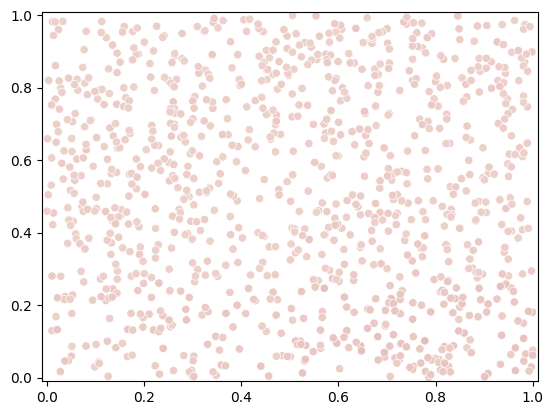

In [21]:
make_plot_square(0.1)

Accuracy of RF model:  1.0


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


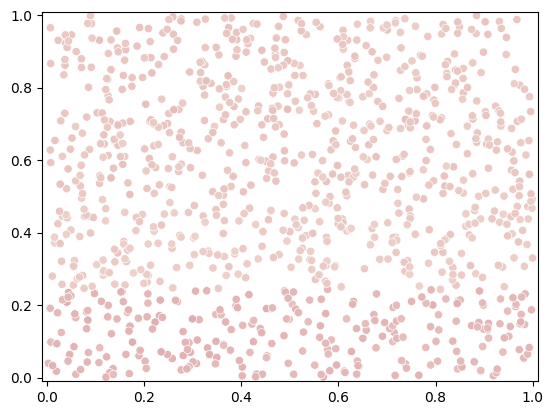

In [22]:
make_plot_square(0.3)

Accuracy of RF model:  1.0


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


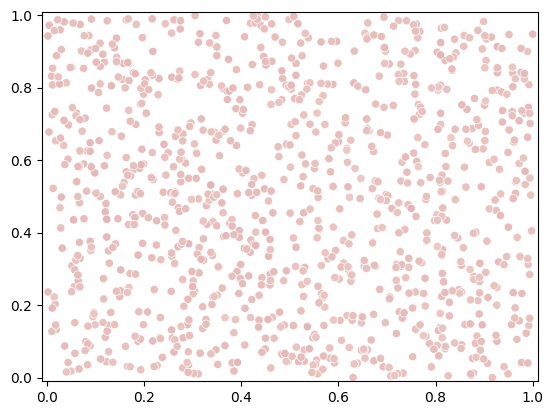

In [23]:
make_plot_square(0.5)

Accuracy of RF model:  1.0


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


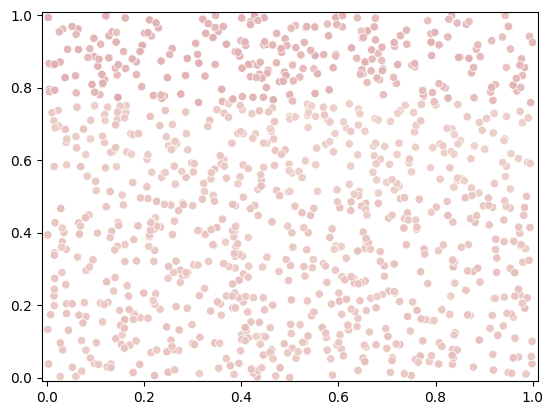

In [24]:
make_plot_square(0.7)

Accuracy of RF model:  1.0


Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


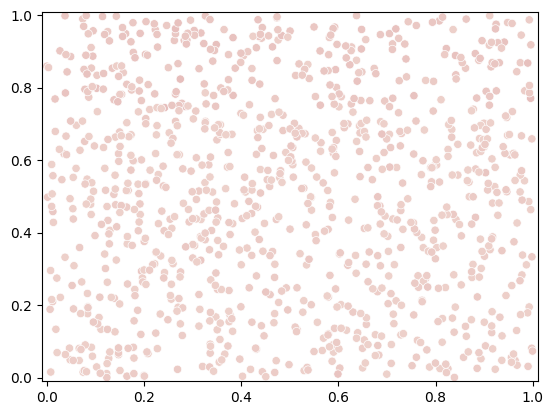

In [25]:
make_plot_square(0.9)

#### Linear with threshold
Here, we use a dataset that has a linear behavior until a threshold, after which the behavior is constant.

In [26]:
# Create 1000 points in a 2D space between 0 and 1
X_linear_dataset = np.random.rand(1000, 2)

# Classify from y=0 to y=0.5 as 0 if x > y, 1 otherwise 0. And if y > 0.8, classify as 0
y_linear_dataset = np.array([
    0 if (x[0] > x[1] and x[1] < 0.5) 
    else 1 for x in X_linear_dataset])

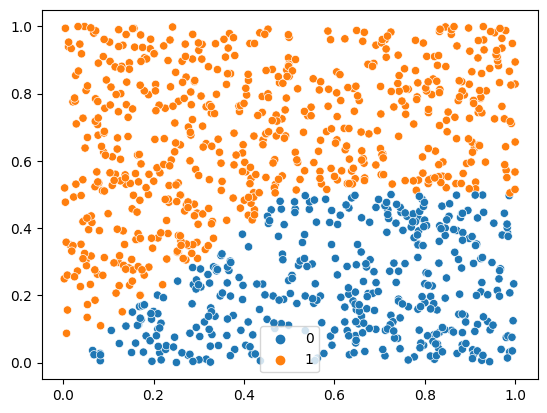

In [27]:
# Plot the points
sns.scatterplot(x=X_linear_dataset[:,0], y=X_linear_dataset[:,1], hue=y_linear_dataset)
plt.savefig('linear_dataset.pdf')

In [28]:
# Create RF model for linear dataset
linear_data_model = RandomForestClassifier(random_state=42)

In [29]:
# Train RF model
linear_data_model.fit(X_linear_dataset, y_linear_dataset)

RandomForestClassifier(random_state=42)

In [30]:
# Print the accuracy of the RF model
print("Accuracy of RF model: ", linear_data_model.score(X_linear_dataset, y_linear_dataset))

Accuracy of RF model:  1.0


In [31]:
# Select all points
linear_0_class_points = X_linear_dataset

In [32]:
# Create NICE counterfactuals for 0 classified points
linear_data_nice_cf = NICE(
    predict_fn=linear_data_model.predict_proba, 
    X_train=X_linear_dataset, 
    y_train=y_linear_dataset, 
    cat_feat=[])
linear_data_cfs = [linear_data_nice_cf.explain(np.array([x])) for x in linear_0_class_points]

# Create CounterPlot Explanation Generator
linear_data_ctp_exp = counterplot_explainer(
    lambda x: linear_data_nice_cf.explain(np.array([x]))[0], 
    ['x1', 'x2'], 
    {0: '0', 1: '1'},
    linear_data_model.predict_proba)

# Create CounterPlot explanations
linear_data_cpt_results, linear_data_cpt_results_idx, linear_data_cpt_gen_times = generate_explanations(
    linear_0_class_points, linear_data_ctp_exp.explain)

In [33]:
# Create SHAP explainer object
linear_data_shap = shap.KernelExplainer(linear_data_model.predict_proba, X_linear_dataset)

# Create SHAP explanation generator
linear_data_shap_exp = shap_explainer(linear_data_shap.shap_values)

# Create SHAP explanations
linear_data_shap_results, linear_data_shap_results_idx, linear_data_shap_gen_times = generate_explanations(
    linear_0_class_points, linear_data_shap_exp.explain)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [34]:
# Create LIME explainer object
linear_data_lime = lime.lime_tabular.LimeTabularExplainer(
    X_linear_dataset, 
    feature_names=["x1", "x2"], 
    class_names={0: "0", 1: "1"})

# Create LIME explanation generator
linear_data_lime_exp = lime_explainer(linear_data_lime, linear_data_model.predict_proba)

# Create LIME explanations
linear_data_lime_results, linear_data_lime_results_idx, linear_data_lime_gen_times = generate_explanations(
    linear_0_class_points, linear_data_lime_exp.explain)

In [35]:
# Get average importance values for each feature

linear_data_fi_avg_cpt = pd.DataFrame(linear_data_cpt_results_idx).mean().sort_index()
linear_data_fi_avg_shap = pd.DataFrame(linear_data_shap_results_idx).mean().sort_index()
linear_data_fi_avg_lime = pd.DataFrame(linear_data_lime_results_idx).mean().sort_index()

pd.DataFrame([linear_data_fi_avg_cpt, linear_data_fi_avg_shap, linear_data_fi_avg_lime], index=['CounterPlot', 'SHAP', 'LIME'])

,0,1
CounterPlot,4.601100e-01,7.470803e-01
SHAP,-5.204726e-16,-2.930989e-17
LIME,-8.376620e-04,9.906249e-05


In [36]:
# Get overall statistics for each explanation method
pd.DataFrame(linear_data_cpt_results_idx).describe()

,1,0
count,947.000000,409.000000
mean,0.747080,0.460110
std,0.252409,0.123903
min,0.180000,0.135000
25%,0.455000,0.425000
50%,0.870000,0.465000
75%,0.980000,0.475000
max,1.000000,0.910000


In [37]:
# Get overall statistics for each explanation method
pd.DataFrame(linear_data_shap_results_idx).describe()

,0,1
count,1.000000e+03,1.000000e+03
mean,-5.204726e-16,-2.930989e-17
std,1.871080e-01,4.088682e-01
min,-2.856650e-01,-6.915750e-01
25%,-8.844500e-02,-4.277375e-01
50%,-5.815000e-02,5.674500e-02
75%,7.996000e-02,4.405900e-01
max,5.787700e-01,4.520300e-01


In [38]:
# Get overall statistics for each explanation method
pd.DataFrame(linear_data_lime_results_idx).describe()

,0,1
count,1000.000000,1000.000000
mean,-0.000838,0.000099
std,0.185376,0.524071
min,-0.222064,-0.722362
25%,-0.146621,-0.460805
50%,-0.062955,0.109238
75%,0.104310,0.513484
max,0.389650,0.548881


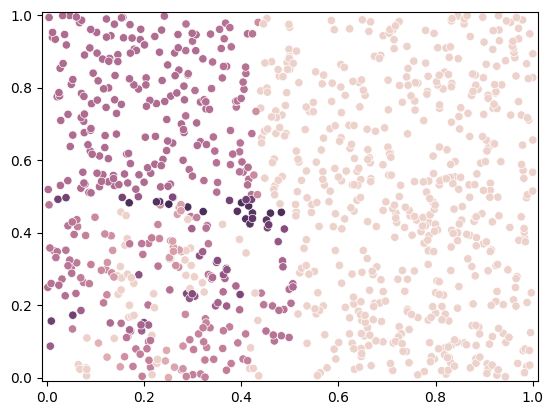

In [39]:
plot_exp_fi(linear_data_cpt_results_idx, linear_0_class_points, 'x')
plt.savefig('linear_cpt_x.pdf')

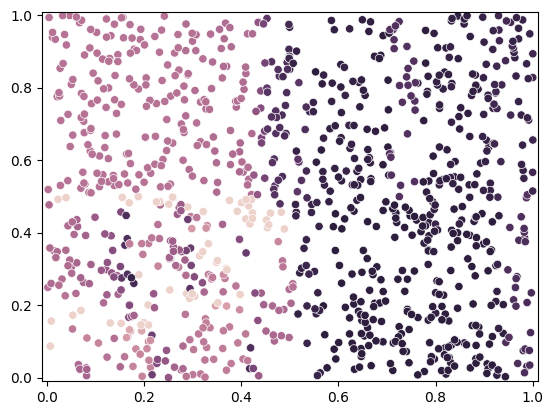

In [40]:
plot_exp_fi(linear_data_cpt_results_idx, linear_0_class_points, 'y')
plt.savefig('linear_cpt_y.pdf')

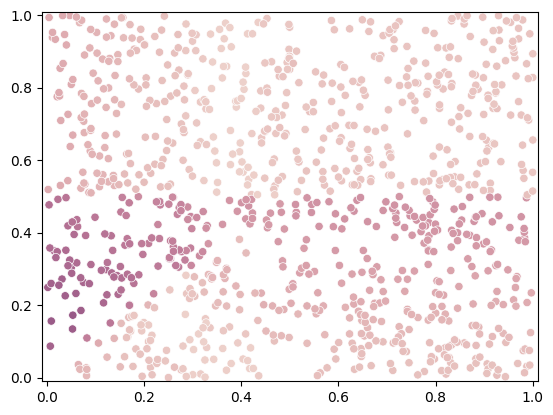

In [41]:
plot_exp_fi(linear_data_shap_results_idx, linear_0_class_points, 'x')
plt.savefig('linear_shap_x.pdf')

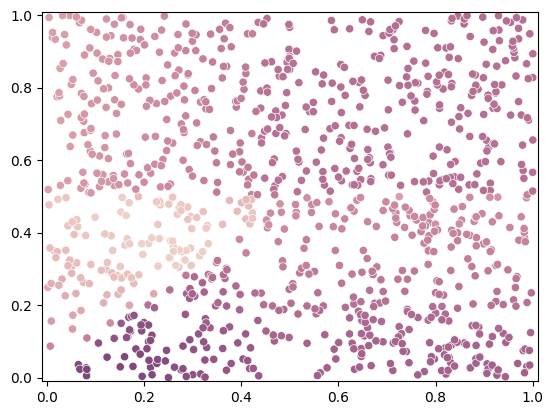

In [42]:
plot_exp_fi(linear_data_shap_results_idx, linear_0_class_points, 'y')
plt.savefig('linear_shap_y.pdf')

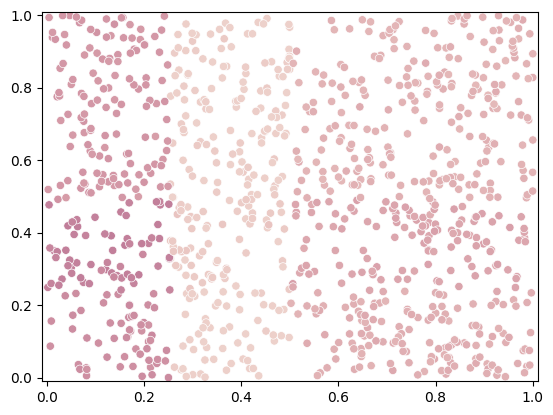

In [43]:
plot_exp_fi(linear_data_lime_results_idx, linear_0_class_points, 'x')
plt.savefig('linear_lime_x.pdf')

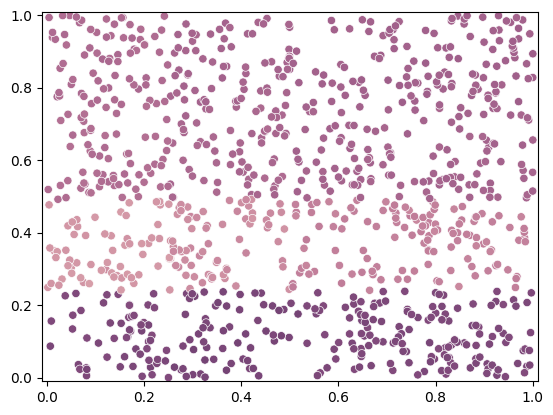

In [44]:
plot_exp_fi(linear_data_lime_results_idx, linear_0_class_points, 'y')
plt.savefig('linear_lime_y.pdf')

#### Circular threshold

Here, we use a dataset that has a circular behavior until a threshold, after which the behavior is constant.

In [45]:
# Create 1000 points in a 2D space between 0 and 1
X_circle_dataset = np.random.rand(1000, 2)

# Considering a circle with radius 0.25 and center (0.5, 0.5), 
# inside the circle is class 0 and outside is class 1
y_circle_dataset = np.array(
    [ 0 if (x[0]-0.5)**2 + (x[1]-0.5)**2 < 0.125 
     else 1 for x in X_circle_dataset])

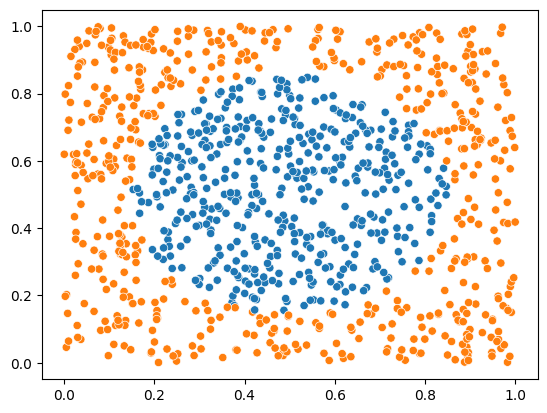

In [46]:
# Plot the points
sns.scatterplot(x=X_circle_dataset[:,0], y=X_circle_dataset[:,1], hue=y_circle_dataset)
# Remove legend
plt.legend().remove()
plt.savefig('circle_dataset.pdf')

In [47]:
# Create RF model for linear dataset
circle_data_model = RandomForestClassifier(random_state=42)

In [48]:
# Train RF model
circle_data_model.fit(X_circle_dataset, y_circle_dataset)

RandomForestClassifier(random_state=42)

In [49]:
# Print the accuracy of the RF model
print("Accuracy of RF model: ", circle_data_model.score(X_circle_dataset, y_circle_dataset))

Accuracy of RF model:  1.0


In [50]:
# Select all points
circle_0_class_points = X_circle_dataset

In [51]:
# Create NICE counterfactuals for 0 classified points
circle_data_nice_cf = NICE(
    predict_fn=circle_data_model.predict_proba, 
    X_train=X_circle_dataset, 
    y_train=y_circle_dataset, 
    cat_feat=[])
circle_data_cfs = [circle_data_nice_cf.explain(np.array([x])) for x in circle_0_class_points]

# Create CounterPlot Explanation Generator
circle_data_ctp_exp = counterplot_explainer(
    lambda x: circle_data_nice_cf.explain(np.array([x]))[0], 
    ['x1', 'x2'], 
    {0: '0', 1: '1'},
    circle_data_model.predict_proba)

# Create CounterPlot explanations
circle_data_cpt_results, circle_data_cpt_results_idx, circle_data_cpt_gen_times = generate_explanations(
    circle_0_class_points, circle_data_ctp_exp.explain)

In [52]:
# Create SHAP explainer object
circle_data_shap = shap.KernelExplainer(circle_data_model.predict_proba, X_circle_dataset)

# Create SHAP explanation generator
circle_data_shap_exp = shap_explainer(circle_data_shap.shap_values)

# Create SHAP explanations
circle_data_shap_results, circle_data_shap_results_idx, circle_data_shap_gen_times = generate_explanations(
    circle_0_class_points, circle_data_shap_exp.explain)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [53]:
# Create LIME explainer object
circle_data_lime = lime.lime_tabular.LimeTabularExplainer(
    X_circle_dataset, 
    feature_names=["x1", "x2"], 
    class_names={0: "0", 1: "1"})

# Create LIME explanation generator
circle_data_lime_exp = lime_explainer(circle_data_lime, circle_data_model.predict_proba)

# Create LIME explanations
circle_data_lime_results, circle_data_lime_results_idx, circle_data_lime_gen_times = generate_explanations(
    circle_0_class_points, circle_data_lime_exp.explain)

In [54]:
# Get average importance values for each feature

circle_data_fi_avg_cpt = pd.DataFrame(circle_data_cpt_results_idx).mean().sort_index()
circle_data_fi_avg_shap = pd.DataFrame(circle_data_shap_results_idx).mean().sort_index()
circle_data_fi_avg_lime = pd.DataFrame(circle_data_lime_results_idx).mean().sort_index()

pd.DataFrame([circle_data_fi_avg_cpt, circle_data_fi_avg_shap, circle_data_fi_avg_lime], index=['CounterPlot', 'SHAP', 'LIME'])

,0,1
CounterPlot,6.726475e-01,6.575723e-01
SHAP,-3.073097e-16,-1.527667e-16
LIME,-8.741209e-04,-1.166872e-03


In [55]:
# Get overall statistics for each explanation method
pd.DataFrame(circle_data_cpt_results_idx).describe()

,1,0
count,622.000000,627.000000
mean,0.657572,0.672648
std,0.241560,0.230159
min,0.120000,0.105000
25%,0.457500,0.455000
50%,0.660000,0.700000
75%,0.900000,0.890000
max,1.000000,1.000000


In [56]:
# Get overall statistics for each explanation method
pd.DataFrame(circle_data_shap_results_idx).describe()

,0,1
count,1.000000e+03,1.000000e+03
mean,-3.073097e-16,-1.527667e-16
std,3.124545e-01,3.013724e-01
min,-4.214500e-01,-4.614450e-01
25%,-2.779763e-01,-2.565838e-01
50%,-1.078500e-01,-9.983750e-02
75%,2.261800e-01,2.269050e-01
max,5.639100e-01,5.752200e-01


In [57]:
# Get overall statistics for each explanation method
pd.DataFrame(circle_data_lime_results_idx).describe()

,0,1
count,1000.000000,1000.000000
mean,-0.000874,-0.001167
std,0.339564,0.304319
min,-0.401452,-0.362343
25%,-0.340462,-0.305686
50%,-0.009692,-0.000194
75%,0.336059,0.300875
max,0.414878,0.377384


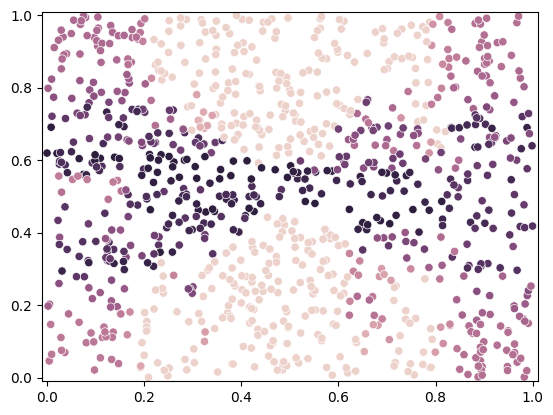

In [58]:
plot_exp_fi(circle_data_cpt_results_idx, circle_0_class_points, 'x')
plt.savefig('circle_cpt_x.pdf')

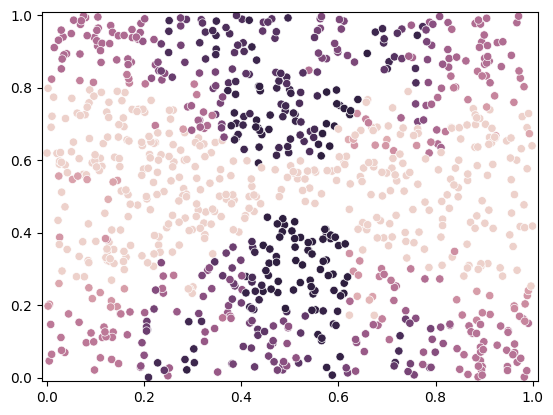

In [59]:
plot_exp_fi(circle_data_cpt_results_idx, circle_0_class_points, 'y')
plt.savefig('circle_cpt_y.pdf')

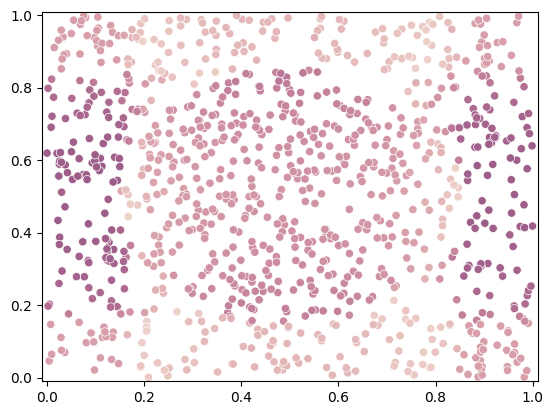

In [60]:
plot_exp_fi(circle_data_shap_results_idx, circle_0_class_points, 'x')
plt.savefig('circle_shap_x.pdf')

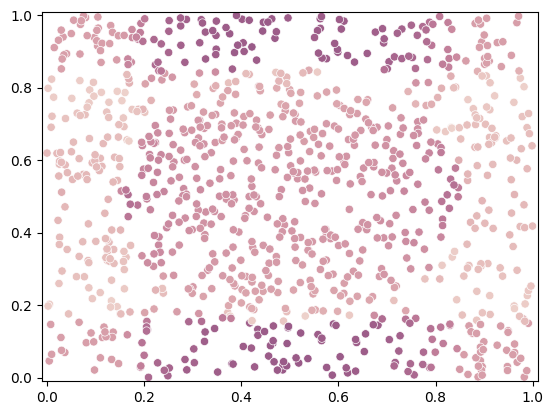

In [61]:
plot_exp_fi(circle_data_shap_results_idx, circle_0_class_points, 'y')
plt.savefig('circle_shap_y.pdf')

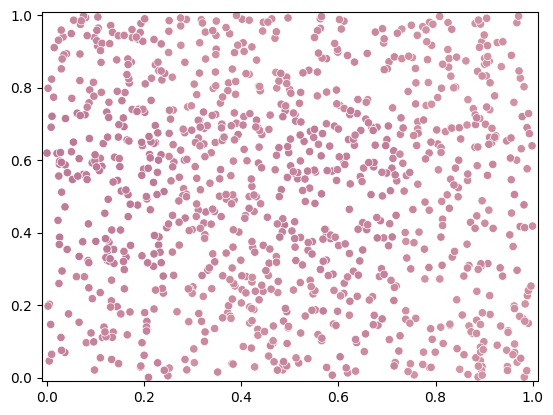

In [62]:
plot_exp_fi(circle_data_lime_results_idx, circle_0_class_points, 'x')
plt.savefig('circle_lime_x.pdf')

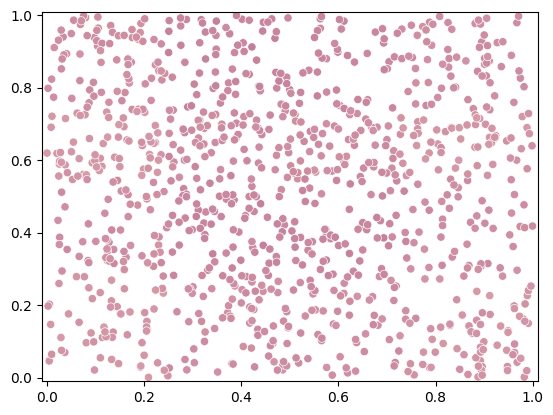

In [63]:
plot_exp_fi(circle_data_lime_results_idx, circle_0_class_points, 'y')
plt.savefig('circle_lime_y.pdf')